<a href="https://colab.research.google.com/github/sultanbst123/EfficientNetV2-with-TPU/blob/main/EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with EfficientNetV2

## Library & File

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import os

#DL library
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_hub as hub 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [ ]:

# load cifar10

(x_train,y_train),(x_test, y_test)= tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

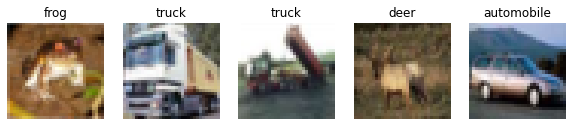

In [ ]:
plt.figure(figsize=(10, 10))
 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis(False)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
   
plt.show()

In [ ]:
#x_train = x_train.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)

#x_test = x_test.astype("float32") / 255.0
#y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:

#split 90:10

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.1, random_state=42)

In [ ]:
x_train.shape, x_val.shape, x_test.shape## cifar 10

((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

## Hyperparameters & TPU

In [ ]:
pip install -U keras-efficientnet-v2

In [ ]:
import keras_efficientnet_v2

In [ ]:
try: # <== detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # <== detect GPU/CPU
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

In [ ]:
# buat dataset 

auto = tf.data.AUTOTUNE
bc = 16 * strategy.num_replicas_in_sync

train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.shuffle(1000).batch(bc).prefetch(auto)

val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_ds = val_ds.batch(bc).prefetch(auto)

In [ ]:
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>,
 <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>)

In [ ]:
# Hyperparamters for fit 

EPOCHS = 25
INIT_LR = 1e-4 
MAX_LR = 5e-2
Wd = 1e-5

#define Callbacks and learning rate scheduler
steps_per_epoch =  len(x_train) // bc

clr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    step_size= 2 * steps_per_epoch
)
# early stop
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True)

#define optimizers 
ADAM = tf.keras.optimizers.Adam(learning_rate=clr)
SGD = tf.keras.optimizers.SGD(learning_rate=clr, momentum=0.9)
 
ADABELIEF = tfa.optimizers.AdaBelief(learning_rate = clr, weight_decay = Wd)#recified == True default,  warmup 0.1
ADAMW = tfa.optimizers.AdamW(learning_rate = clr, weight_decay = Wd)

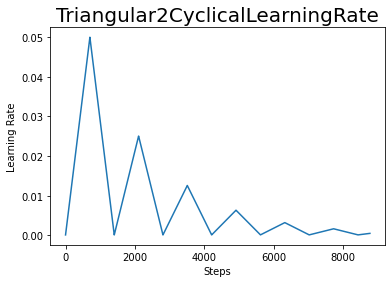

In [ ]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Triangular2CyclicalLearningRate", size=20)
plt.show()

## EfficientnetV2B0

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(224, 224), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:
with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 224
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2B0(input_shape=(224,224,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name = "EfficientNetV2B0") 
   

    # freeze EfficientNetV2B0
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b0-imagenet.h5
Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2B0 (Functiona  (None, 7, 7, 1280)       5919312   
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)    

In [ ]:
cp_path = f"best_cp[0].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 127s 252ms/step - loss: 0.7164 - accuracy: 0.7660 - top-5-accuracy: 0.9540 - val_loss: 0.3378 - val_accuracy: 0.8834 - val_top-5-accuracy: 0.9950
Epoch 2/25
352/352 [==============================] - 13s 38ms/step - loss: 0.4620 - accuracy: 0.8607 - top-5-accuracy: 0.9946 - val_loss: 0.5895 - val_accuracy: 0.8464 - val_top-5-accuracy: 0.9922
Epoch 3/25
352/352 [==============================] - 14s 39ms/step - loss: 0.5307 - accuracy: 0.8677 - top-5-accuracy: 0.9951 - val_loss: 0.4244 - val_accuracy: 0.8890 - val_top-5-accuracy: 0.9960
Epoch 4/25
352/352 [==============================] - 16s 44ms/step - loss: 0.3414 - accuracy: 0.9000 - top-5-accuracy: 0.9977 - val_loss: 0.3343 - val_accuracy: 0.9040 - val_top-5-accuracy: 0.9976
Epoch 5/25
352/352 [==============================] - 14s 39ms/step - loss: 0.2777 - accuracy: 0.9115 - top-5-accuracy: 0.9984 - val_loss: 0.3670 - val_accuracy: 0.8938 - val_top-5-accuracy: 0.9966
Epoch 6/

In [ ]:
loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 3s 32ms/step - loss: 0.3148 - accuracy: 0.9068 - top-5-accuracy: 0.9976
Val loss: 0.31
Val accuracy: 90.68%
Val top 5 accuracy: 99.76%


In [ ]:

# coba di data test(unseen)

y_true = y_test.flatten()

y_predu = model.predict(x_test)

In [ ]:
# effv2 b0
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 89.86%


##EfficientnetV2B1

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(240, 240), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:
with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 240
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2B1(input_shape=(240,240,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name = "EfficientNetV2B1") 
   

    # freeze EfficientNetV2B1
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

33783808/33773048 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b1-imagenet.h5
Model: "EfficientNetV2B1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 240, 240, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2B1 (Functiona  (None, 8, 8, 1280)       6931124   
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                         

In [ ]:
cp_path = f"best_cp[1].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 85s 159ms/step - loss: 0.4486 - accuracy: 0.8493 - top-5-accuracy: 0.9906 - val_loss: 0.3362 - val_accuracy: 0.8866 - val_top-5-accuracy: 0.9958
Epoch 2/25
352/352 [==============================] - 20s 56ms/step - loss: 0.3318 - accuracy: 0.8870 - top-5-accuracy: 0.9973 - val_loss: 0.3103 - val_accuracy: 0.8944 - val_top-5-accuracy: 0.9966
Epoch 3/25
352/352 [==============================] - 20s 57ms/step - loss: 0.3093 - accuracy: 0.8946 - top-5-accuracy: 0.9975 - val_loss: 0.3026 - val_accuracy: 0.8964 - val_top-5-accuracy: 0.9976
Epoch 4/25
352/352 [==============================] - 18s 51ms/step - loss: 0.3022 - accuracy: 0.8974 - top-5-accuracy: 0.9977 - val_loss: 0.3008 - val_accuracy: 0.8958 - val_top-5-accuracy: 0.9974
Epoch 5/25
352/352 [==============================] - 19s 55ms/step - loss: 0.2998 - accuracy: 0.8976 - top-5-accuracy: 0.9978 - val_loss: 0.2968 - val_accuracy: 0.8988 - val_top-5-accuracy: 0.9978
Epoch 6/2

In [ ]:
loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val  accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 3s 37ms/step - loss: 0.2718 - accuracy: 0.9076 - top-5-accuracy: 0.9978
Val loss: 0.27
Val  accuracy: 90.76%
Val top 5 accuracy: 99.78%


In [ ]:
# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 b1
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 90.07%


##EfficientNetV2B2

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(260, 260), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 260
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2B2(input_shape=(260,260,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name = "EfficientNetV2B2") 
   

    # freeze EfficientNetV2B2
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

41689088/41675584 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b2-imagenet.h5
Model: "EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 260, 260, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2B2 (Functiona  (None, 9, 9, 1408)       8769374   
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                         

In [ ]:
cp_path = f"best_cp[2].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 78s 145ms/step - loss: 0.7783 - accuracy: 0.7619 - top-5-accuracy: 0.9763 - val_loss: 0.5801 - val_accuracy: 0.8156 - val_top-5-accuracy: 0.9918
Epoch 2/25
352/352 [==============================] - 19s 55ms/step - loss: 0.5551 - accuracy: 0.8220 - top-5-accuracy: 0.9913 - val_loss: 0.5247 - val_accuracy: 0.8318 - val_top-5-accuracy: 0.9924
Epoch 3/25
352/352 [==============================] - 19s 54ms/step - loss: 0.5132 - accuracy: 0.8328 - top-5-accuracy: 0.9923 - val_loss: 0.4967 - val_accuracy: 0.8378 - val_top-5-accuracy: 0.9936
Epoch 4/25
352/352 [==============================] - 19s 54ms/step - loss: 0.4894 - accuracy: 0.8396 - top-5-accuracy: 0.9934 - val_loss: 0.4773 - val_accuracy: 0.8412 - val_top-5-accuracy: 0.9940
Epoch 5/25
352/352 [==============================] - 20s 58ms/step - loss: 0.4722 - accuracy: 0.8441 - top-5-accuracy: 0.9939 - val_loss: 0.4633 - val_accuracy: 0.8444 - val_top-5-accuracy: 0.9940
Epoch 6/2

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 3s 40ms/step - loss: 0.3762 - accuracy: 0.8708 - top-5-accuracy: 0.9948
Val loss: 0.38
Val accuracy: 87.08%
Val top 5 accuracy: 99.48%


In [ ]:
# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 b2
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 86.85%


##EfficientNetV2B3

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(300, 300), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 300
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2B3(input_shape=(300,300,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name = "EfficientNetV2B3") 
   

    # freeze EfficientNetV2B3
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

59006976/58991392 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b3-imagenet.h5
Model: "EfficientNetV2B3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 300, 300, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2B3 (Functiona  (None, 10, 10, 1536)     12930622  
 l)                                                              
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                         

In [ ]:

cp_path = f"best_cp[3].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 160s 305ms/step - loss: 0.6538 - accuracy: 0.8055 - top-5-accuracy: 0.9809 - val_loss: 0.4510 - val_accuracy: 0.8612 - val_top-5-accuracy: 0.9950
Epoch 2/25
352/352 [==============================] - 24s 69ms/step - loss: 0.4433 - accuracy: 0.8570 - top-5-accuracy: 0.9940 - val_loss: 0.4043 - val_accuracy: 0.8714 - val_top-5-accuracy: 0.9966
Epoch 3/25
352/352 [==============================] - 24s 69ms/step - loss: 0.4086 - accuracy: 0.8655 - top-5-accuracy: 0.9954 - val_loss: 0.3814 - val_accuracy: 0.8762 - val_top-5-accuracy: 0.9972
Epoch 4/25
352/352 [==============================] - 24s 69ms/step - loss: 0.3887 - accuracy: 0.8710 - top-5-accuracy: 0.9954 - val_loss: 0.3665 - val_accuracy: 0.8780 - val_top-5-accuracy: 0.9978
Epoch 5/25
352/352 [==============================] - 24s 68ms/step - loss: 0.3748 - accuracy: 0.8751 - top-5-accuracy: 0.9956 - val_loss: 0.3555 - val_accuracy: 0.8804 - val_top-5-accuracy: 0.9978
Epoch 6/

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 3s 51ms/step - loss: 0.2873 - accuracy: 0.9038 - top-5-accuracy: 0.9980
Val loss: 0.29
Val accuracy: 90.38%
Val top 5 accuracy: 99.8%


In [ ]:

# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 b3
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 89.29%


##EfficientNetV2T

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(320, 320), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope(): 

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 320
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2T(input_shape=(320,320,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name="EfficientNetV2T") 
   

    # freeze EfficientNetV2T
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-t-imagenet.h5
Model: "EfficientNetV2T"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 320, 320, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2T (Functional  (None, 10, 10, 1024)     12743412  
 )                                                               
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)      

In [ ]:

cp_path = f"best_cp[T].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


352/352 [==============================] - 127s 242ms/step - loss: 0.6391 - accuracy: 0.8030 - top-5-accuracy: 0.9612 - val_loss: 0.2784 - val_accuracy: 0.9036 - val_top-5-accuracy: 0.9970
Epoch 2/25
352/352 [==============================] - 21s 61ms/step - loss: 0.3135 - accuracy: 0.8993 - top-5-accuracy: 0.9964 - val_loss: 0.3438 - val_accuracy: 0.8972 - val_top-5-accuracy: 0.9960
Epoch 3/25
352/352 [==============================] - 23s 65ms/step - loss: 0.3554 - accuracy: 0.9010 - top-5-accuracy: 0.9967 - val_loss: 0.3524 - val_accuracy: 0.9056 - val_top-5-accuracy: 0.9972
Epoch 4/25
352/352 [==============================] - 24s 70ms/step - loss: 0.2545 - accuracy: 0.9208 - top-5-accuracy: 0.9982 - val_loss: 0.2387 - val_accuracy: 0.9288 - val_top-5-accuracy: 0.9980
Epoch 5/25
352/352 [==============================] - 21s 61ms/step - loss: 0.2071 - accuracy: 0.9319 - top-5-accuracy: 0.9988 - val_loss: 0.2681 - val_accuracy: 0.9196 - val_top-5-accuracy: 0.9978
Epoch 6/25
352/352 

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 5s 64ms/step - loss: 0.2242 - accuracy: 0.9280 - top-5-accuracy: 0.9986
Val loss: 0.22
Val accuracy: 92.8%
Val top 5 accuracy: 99.86%


In [ ]:

# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 T
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 92.53%


##EfficientNetV2S

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(384, 384), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope(): 
    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 384
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2S(input_shape=(384,384,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name="EfficientNetV2S") 
   

    # freeze EfficientNetV2S
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

87859200/87846816 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5
Model: "EfficientNetV2S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 384, 384, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2S (Functional  (None, 12, 12, 1280)     20331360  
 )                                                               
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                           

In [ ]:

cp_path = f"best_cp[S].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 151s 287ms/step - loss: 0.4468 - accuracy: 0.8510 - top-5-accuracy: 0.9894 - val_loss: 0.3379 - val_accuracy: 0.8796 - val_top-5-accuracy: 0.9974
Epoch 2/25
352/352 [==============================] - 35s 99ms/step - loss: 0.3351 - accuracy: 0.8853 - top-5-accuracy: 0.9957 - val_loss: 0.3153 - val_accuracy: 0.8882 - val_top-5-accuracy: 0.9974
Epoch 3/25
352/352 [==============================] - 32s 90ms/step - loss: 0.3146 - accuracy: 0.8933 - top-5-accuracy: 0.9961 - val_loss: 0.3094 - val_accuracy: 0.8900 - val_top-5-accuracy: 0.9972
Epoch 4/25
352/352 [==============================] - 32s 91ms/step - loss: 0.3081 - accuracy: 0.8965 - top-5-accuracy: 0.9964 - val_loss: 0.3074 - val_accuracy: 0.8920 - val_top-5-accuracy: 0.9974
Epoch 5/25
352/352 [==============================] - 31s 89ms/step - loss: 0.3058 - accuracy: 0.8961 - top-5-accuracy: 0.9965 - val_loss: 0.3031 - val_accuracy: 0.8928 - val_top-5-accuracy: 0.9978
Epoch 6/

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 5s 80ms/step - loss: 0.2861 - accuracy: 0.8994 - top-5-accuracy: 0.9974
Val loss: 0.29
Val accuracy: 89.94%
Val top 5 accuracy: 99.74%


In [ ]:

# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 S
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 89.27%


##EfficientNetV2M

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(480, 480), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 480
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2M(input_shape=(480,480,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name="EfficientNetV2M") 
   

    # freeze EfficientNetV2M
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

219758592/219746704 [==============================] - 4s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-m-imagenet.h5
Model: "EfficientNetV2M"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 480, 480, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2M (Functional  (None, 15, 15, 1280)     53150388  
 )                                                               
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                         

In [ ]:

cp_path = f"best_cp[M].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 219s 440ms/step - loss: 0.5858 - accuracy: 0.8426 - top-5-accuracy: 0.9831 - val_loss: 0.3922 - val_accuracy: 0.8814 - val_top-5-accuracy: 0.9944
Epoch 2/25
352/352 [==============================] - 65s 184ms/step - loss: 0.3729 - accuracy: 0.8844 - top-5-accuracy: 0.9941 - val_loss: 0.3495 - val_accuracy: 0.8912 - val_top-5-accuracy: 0.9952
Epoch 3/25
352/352 [==============================] - 65s 186ms/step - loss: 0.3431 - accuracy: 0.8902 - top-5-accuracy: 0.9948 - val_loss: 0.3287 - val_accuracy: 0.8968 - val_top-5-accuracy: 0.9958
Epoch 4/25
352/352 [==============================] - 65s 186ms/step - loss: 0.3263 - accuracy: 0.8942 - top-5-accuracy: 0.9953 - val_loss: 0.3152 - val_accuracy: 0.8998 - val_top-5-accuracy: 0.9964
Epoch 5/25
352/352 [==============================] - 64s 181ms/step - loss: 0.3134 - accuracy: 0.8986 - top-5-accuracy: 0.9955 - val_loss: 0.3050 - val_accuracy: 0.9006 - val_top-5-accuracy: 0.9964
Epoc

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 7s 138ms/step - loss: 0.2458 - accuracy: 0.9186 - top-5-accuracy: 0.9970
Val loss: 0.25
Val accuracy: 91.86%
Val top 5 accuracy: 99.7%


In [ ]:

# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 M
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 90.53%


##EfficientNetV2L

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(480, 480), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 480
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2L(input_shape=(480,480,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name="EfficientNetV2L") 
   

    # freeze EfficientNetV2L
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]

    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

478912512/478901992 [==============================] - 25s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-l-imagenet.h5
Model: "EfficientNetV2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 480, 480, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2L (Functional  (None, 15, 15, 1280)     117746848 
 )                                                               
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                        

In [ ]:

cp_path = f"best_cp[L].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
352/352 [==============================] - 261s 529ms/step - loss: 0.5698 - accuracy: 0.8604 - top-5-accuracy: 0.9867 - val_loss: 0.3536 - val_accuracy: 0.8980 - val_top-5-accuracy: 0.9966
Epoch 2/25
352/352 [==============================] - 89s 253ms/step - loss: 0.3402 - accuracy: 0.8970 - top-5-accuracy: 0.9956 - val_loss: 0.3073 - val_accuracy: 0.9038 - val_top-5-accuracy: 0.9970
Epoch 3/25
352/352 [==============================] - 89s 254ms/step - loss: 0.3090 - accuracy: 0.9041 - top-5-accuracy: 0.9961 - val_loss: 0.2861 - val_accuracy: 0.9072 - val_top-5-accuracy: 0.9978
Epoch 4/25
352/352 [==============================] - 89s 253ms/step - loss: 0.2910 - accuracy: 0.9086 - top-5-accuracy: 0.9964 - val_loss: 0.2723 - val_accuracy: 0.9108 - val_top-5-accuracy: 0.9980
Epoch 5/25
352/352 [==============================] - 89s 253ms/step - loss: 0.2791 - accuracy: 0.9106 - top-5-accuracy: 0.9967 - val_loss: 0.2624 - val_accuracy: 0.9126 - val_top-5-accuracy: 0.9982
Epoc

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 11s 226ms/step - loss: 0.2045 - accuracy: 0.9310 - top-5-accuracy: 0.9980
Val loss: 0.2
Val accuracy: 93.1%
Val top 5 accuracy: 99.8%


In [ ]:

# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 L
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 92.38%


##EfficientNetV2XL

In [ ]:

data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0), # [0, 1] 
        layers.Resizing(512, 512), # resize image 
        #layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:

with strategy.scope():

    # /// get model ////
    input = layers.Input(shape=(32, 32,3))

    # resize image 32 to 512
    x = data_augmentation(input)

    # num_classes = 0 == include_top = False 
    # include preprocessing = True, will add rescale and normalization layers 
    Eff = keras_efficientnet_v2.EfficientNetV2XL(input_shape=(512,512,3),num_classes = 0,pretrained="imagenet21k-ft1k",include_preprocessing = True)(x)

    # add fc      
    x1 = layers.GlobalAveragePooling2D()(Eff)
    x1 = layers.Dropout(0.1)(x1) 
    output = layers.Dense(10, activation="softmax")(x1)

    model = tf.keras.Model(inputs=input, outputs=output, name="EfficientNetV2XL") 
   

    # freeze EfficientNetV2XL
    for layer in model.layers[2:3]:
        layer.trainable = False

    #define metrics
    METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
               tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]
  
    #compile model 
    model.compile(optimizer = ADABELIEF, 
              loss = "CategoricalCrossentropy",
              metrics = METRICS)

model.summary()

839172096/839155800 [==============================] - 8s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-xl-21k-ft1k.h5
Model: "EfficientNetV2XL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 512, 512, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2XL (Functiona  (None, 16, 16, 1280)     207615832 
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                       

In [ ]:

cp_path = f"best_cp[XL].hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/25
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


352/352 [==============================] - 328s 689ms/step - loss: 0.5289 - accuracy: 0.8416 - top-5-accuracy: 0.9495 - val_loss: 0.3043 - val_accuracy: 0.9326 - val_top-5-accuracy: 0.9972
Epoch 2/25
352/352 [==============================] - 114s 324ms/step - loss: 0.3933 - accuracy: 0.9438 - top-5-accuracy: 0.9973 - val_loss: 0.7798 - val_accuracy: 0.9268 - val_top-5-accuracy: 0.9976
Epoch 3/25
352/352 [==============================] - 115s 325ms/step - loss: 0.6033 - accuracy: 0.9535 - top-5-accuracy: 0.9986 - val_loss: 0.5212 - val_accuracy: 0.9618 - val_top-5-accuracy: 0.9986
Epoch 4/25
352/352 [==============================] - 114s 324ms/step - loss: 0.2845 - accuracy: 0.9719 - top-5-accuracy: 0.9996 - val_loss: 0.3294 - val_accuracy: 0.9684 - val_top-5-accuracy: 0.9990
Epoch 5/25
352/352 [==============================] - 114s 325ms/step - loss: 0.1876 - accuracy: 0.9774 - top-5-accuracy: 0.9998 - val_loss: 0.4028 - val_accuracy: 0.9644 - val_top-5-accuracy: 0.9988
Epoch 6/25


In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

40/40 [==============================] - 13s 283ms/step - loss: 0.3043 - accuracy: 0.9324 - top-5-accuracy: 0.9972
Val loss: 0.3
Val accuracy: 93.24%
Val top 5 accuracy: 99.72%


In [ ]:

# coba di data test(unseen)
y_true = y_test.flatten()
y_predu = model.predict(x_test)

# effv2 XL
acc = accuracy_score(y_true, np.argmax(y_predu,axis=1))

print(f"Test accuracy: {round(acc * 100, 2)}%")

Test accuracy: 93.41%
